In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pymongo import MongoClient
from mplsoccer import Pitch
import utils
import json


client = MongoClient()
db = client['football_data']

In [2]:
#wczytanie danych
home_team = 'Real Madrid'
away_team = 'Barcelona'

match = pd.DataFrame(list(db.matches.find({'home_team' : home_team, 'away_team' : away_team}))).iloc[0]
match_id = int(match['match_id'])

events = pd.DataFrame(list(db.events.find({'match_id' : match_id})))
events['minute'] = events['minute'] + 1
lineups = pd.DataFrame(list(db.lineups.find({'match_id' : match_id})))

events, lineups = utils.apply_nicknames(events, lineups) #zmiana pełnych nazwisk na te które każdy zna

In [3]:
#podstawowe informacje
print(f"{match['home_team']} vs {match['away_team']}")
print(f"Wynik: {match['home_score']} - {match['away_score']}")
print(f"Data: {match['match_date']}")
print(f"Kolejka: {match.get('match_week')}")
print(f"Stadion: {match.get('stadium')}")

referee = match.get('referee')
print(f"Sędzia: {'brak danych' if pd.isnull(referee) else referee}")


Real Madrid vs Barcelona
Wynik: 0 - 4
Data: 2015-11-21
Kolejka: 12
Stadion: Estadio Santiago Bernabéu
Sędzia: David Fernández Borbalan


In [4]:
#Składy
starting_11 = events[events['type'] == 'Starting XI']

home_team = match['home_team']
away_team = match['away_team']

home_manager = match['home_managers']
away_manager = match['away_managers']

home_players = []
away_players = []

#Wyjściowa 11stka z events
starting_ids = set()
for _, row in starting_11.iterrows():
    lineup = row['tactics']['lineup']
    for player in lineup:
        starting_ids.add(player['player']['id'])

for _, row in starting_11.iterrows():
    team = row['team']
    lineup = row['tactics']['lineup']
    
    for player in lineup:
        player_entry = {
            'Numer': player['jersey_number'],
            'Zawodnik': player['player']['name'],
            'Pozycja': player['position']['name']
        }
        if team == home_team:
            home_players.append(player_entry)
        elif team == away_team:
            away_players.append(player_entry)

home_df = pd.DataFrame(home_players)
away_df = pd.DataFrame(away_players)
home_df.reset_index(drop=True, inplace=True)
away_df.reset_index(drop=True, inplace=True)

#Rezerwowi
#lineups zawiera wszystkich zawodników łącznie z ławką i trzeba odseparować rezerwowych
subs_home = lineups[
    (lineups['team'] == home_team) & (~lineups['player_id'].isin(starting_ids))][['jersey_number', 'player_name']]

subs_away = lineups[
    (lineups['team'] == away_team) & (~lineups['player_id'].isin(starting_ids))][['jersey_number', 'player_name']]



print(f"Wyjściowa jedenastka - {home_team}")
print(f"Trener: {home_manager}")
display(home_df)

print(f"Rezerwowi - {home_team}")
display(subs_home)

print(f"\nWyjściowa jedenastka - {away_team}")
print(f"Trener: {away_manager}")
display(away_df)

print(f"Rezerwowi - {away_team}")
display(subs_away)

Wyjściowa jedenastka - Real Madrid
Trener: Rafael Benítez Maudes


,Numer,Zawodnik,Pozycja
0,1,Keylor Navas,Goalkeeper
1,23,Danilo,Right Back
2,2,Raphaël Varane,Right Center Back
3,4,Sergio Ramos,Left Center Back
4,12,Marcelo,Left Back
5,19,Luka Modrić,Right Defensive Midfield
6,8,Toni Kroos,Left Defensive Midfield
7,10,James Rodríguez,Right Wing
8,11,Gareth Bale,Center Attacking Midfield
9,7,Cristiano Ronaldo,Left Wing


Rezerwowi - Real Madrid


,jersey_number,player_name
1,20,Jesé
2,22,Isco
5,16,Mateo Kovačić
8,14,Casemiro
13,15,Daniel Carvajal
15,13,Kiko Casilla
17,3,Pepe



Wyjściowa jedenastka - Barcelona
Trener: Luis Enrique Martínez García


,Numer,Zawodnik,Pozycja
0,13,Claudio Bravo,Goalkeeper
1,6,Dani Alves,Right Back
2,3,Gerard Piqué,Right Center Back
3,14,Javier Mascherano,Left Center Back
4,18,Jordi Alba,Left Back
5,5,Sergio Busquets,Center Defensive Midfield
6,4,Ivan Rakitić,Right Center Midfield
7,8,Andrés Iniesta,Left Center Midfield
8,20,Sergi Roberto,Right Wing
9,11,Neymar,Left Wing


Rezerwowi - Barcelona


,jersey_number,player_name
18,19,Sandro Ramírez
28,10,Lionel Messi
30,23,Thomas Vermaelen
32,17,Munir El Haddadi
33,24,Jérémy Mathieu
34,1,Marc-André ter Stegen
35,21,Adriano


In [5]:
# Przebieg meczu - najważniejsze wydarzenia

icons = {
    "Yellow Card": "🟨",
    "Second Yellow": "🟨🟥",
    "Red Card": "🟥",
    "Halftime" : "✅",
    "Goal" : "⚽",
    "Own Goal" : "⚽",
    "Goal (Pen)" : "⚽",
    "Half End" : "✅",
    "Own goal" : "❌",
    "Added time" : "🕑",
    "Substitution" : "🔁"
}
timeline = []

# gole(asysty)
normal_goals = events[(events['type'] == 'Shot') & (events['shot_outcome'] == 'Goal')].copy()
own_goals = events[events['type'] == 'Own Goal For'].copy()
goals = pd.concat([normal_goals, own_goals], ignore_index=True)

passes = events[events['type'] == 'Pass'][['id', 'player']]
assist_map = dict(zip(passes['id'], passes['player']))

for _, row in goals.iterrows():
    minute = row['minute']
    team = row.get('team')
    player = row.get('player')

    if row['type'] == 'Shot':
        assist_id = row.get('shot_key_pass_id')
        assistant = assist_map.get(assist_id)
        if assistant:
            player_str = f"{player} (a. {assistant})"
        else:
            player_str = player
        if row.get('shot_type') == 'Penalty':
            event_type = 'Goal (Pen)'
        else:
            event_type = 'Goal'
    else:
        player_str = player
        event_type = 'Own Goal'

    timeline.append({
        'icon' : icons.get(event_type),
        'minute': minute,
        'team': team,
        'player': player_str,
        'type': event_type
    })


#kartki
lineups['cards'] = lineups['cards'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) and x.startswith("[") else x)
for team_name in home_team, away_team:
    team_players = lineups[lineups['team'] == team_name]
    for _, player in team_players.iterrows():
        for card in player.get("cards", []):
            card_type = card.get("card_type")
            time_str = card.get("time", "0:0")
            try:
                minute, second = map(int, time_str.split(":"))
            except:
                minute, second = 0, 0


            timeline.append({
                'icon' : icons.get(card_type),
                'minute': minute + 1,
                'team': team_name,
                'player': player.get("player_name", "Brak danych"),
                'type': card_type
            })


#zmiany
subs = events[events['type'] == 'Substitution'].copy()
subs['minute'] = subs['minute']

for _, row in subs.iterrows():
    timeline.append({
        'icon' : icons.get('Substitution'),
        'minute': row['minute'],
        'team': row.get('team', None),
        'player': f"{row.get('player')} --> {row.get('substitution_replacement')}",
        'type': 'Substitution'
    })

#połowy i doliczony czas
half_ends = (
    events[events['type'] == 'Half End']
    .sort_values(['period', 'minute', 'second'])
    .drop_duplicates(subset='period', keep='last')  #tylko ostatni wpis dla każdej połowy
)

for _, row in half_ends.iterrows():
    period = row.get("period", None)
    minute = row.get("minute", 0)

    if period == 1:
        if minute > 45:
            timeline.append({
                'icon' : icons.get('Added time'),
                'minute': 45,
                'team': '',
                'player': '',
                'type': f'1st Half +{minute - 45} min'
            })
        timeline.append({
            'icon' : icons.get('Half End'),
            'minute': minute,
            'team': '',
            'player': '',
            'type': 'Halftime'
        })

    elif period == 2:
        if minute > 90:
            timeline.append({
                'icon' : icons.get('Added time'),
                'minute': 90,
                'team': '',
                'player': '',
                'type': f'2nd Half +{minute - 90} min'
            })
        timeline.append({
            'icon' : icons.get('Half End'),
            'minute': minute,
            'team': '',
            'player': '',
            'type': 'Fulltime'
        })


timeline_df = pd.DataFrame(timeline)
timeline_df = timeline_df.sort_values(by=['minute']).reset_index(drop=True)
timeline_df = timeline_df[['icon', 'type', 'minute', 'player', 'team']]
print("Przebieg meczu")
display(timeline_df)


Przebieg meczu


,icon,type,minute,player,team
0,⚽,Goal,11,Luis Suárez (a. Sergi Roberto),Barcelona
1,🟨,Yellow Card,23,James Rodríguez,Real Madrid
2,🔁,Substitution,28,Javier Mascherano --> Jérémy Mathieu,Barcelona
3,🟨,Yellow Card,30,Dani Alves,Barcelona
4,⚽,Goal,39,Neymar (a. Andrés Iniesta),Barcelona
5,🕑,1st Half +3 min,45,,
6,✅,Halftime,48,,
7,🟨,Yellow Card,50,Sergio Ramos,Real Madrid
8,⚽,Goal,53,Andrés Iniesta (a. Neymar),Barcelona
9,🔁,Substitution,55,James Rodríguez --> Isco,Real Madrid


In [6]:
#istotne statystyki

# Filtry
home_events = events[events['team'] == home_team]
away_events = events[events['team'] == away_team]

def count_shots(df):
    return len(df[df['type'] == 'Shot'])
home_shots = count_shots(home_events)
away_shots = count_shots(away_events)

def count_shots_on_target(df):
    return len(df[(df['type'] == 'Shot') & (df['shot_outcome'].isin(['Goal', 'Saved']))])
home_on_target = count_shots_on_target(home_events)
away_on_target = count_shots_on_target(away_events)

def sum_xg(df):
    return df[df['type'] == 'Shot']['shot_statsbomb_xg'].sum()
home_xg = round(sum_xg(home_events), 2)
away_xg = round(sum_xg(away_events), 2)

def count_passes(df):
    return df[df['type'] == 'Pass']
home_passes = count_passes(home_events)
away_passes = count_passes(away_events)

def count_accurate_passes(df):
    passes = count_passes(df)
    return len(passes[passes['pass_outcome'].isnull()]) #nan = celne

home_acc_passes = count_accurate_passes(home_passes)
away_acc_passes = count_accurate_passes(away_passes)

def pass_accuracy_pct(df):
    passes = count_passes(df)
    total = len(passes)
    accurate = count_accurate_passes(df)
    return f"{(accurate / total) * 100:.1f}%" if total > 0 else "0.0%"



def count_corners(df):
    return len(df[df['pass_type'] == 'Corner'])

def count_penalties(df):
    return len(df[df['shot_type'] == 'Penalty'])

def count_free_kicks(df):
    return len(df[df['pass_type'] == 'Free Kick'])


#składy w słowniku aby bylo łatwiej znaleźć kartki
lineups_dict = {
    team: group.to_dict(orient="records")
    for team, group in lineups.groupby("team")
}

def count_yellow_cards(team):
    num = 0
    for player in lineups_dict.get(team, []):
        for card in player.get("cards", []):
            if card.get("card_type") in ["Yellow Card", "Second Yellow"]:
                num += 1
    return num

def count_red_cards(team):
    num = 0
    for player in lineups_dict.get(team, []):
        for card in player.get("cards", []):
            if card.get("card_type") in ["Red Card", "Second Yellow"]:
                num += 1
    return num


controlled_events = events[events['type'].isin(['Pass', 'Ball Receipt', 'Carry'])]

home_possession = f"{(len(controlled_events[controlled_events['team'] == home_team]) / len(controlled_events)) * 100:.1f}%"
away_possession = f"{(len(controlled_events[controlled_events['team'] == away_team]) / len(controlled_events)) * 100:.1f}%"


stats = {
    'Gole': [match['home_score'], match['away_score']],
    'Strzały': [home_shots, away_shots],
    'Strzały celne': [home_on_target, away_on_target],
    'xG': [home_xg, away_xg],
    'Posiadanie piłki': [home_possession, away_possession],
    'Celne podania': [home_acc_passes, away_acc_passes],
    'Celność podań': [pass_accuracy_pct(home_events), pass_accuracy_pct(away_events)],
    'Rzuty rożne': [count_corners(home_events), count_corners(away_events)],
    'Rzuty karne': [count_penalties(home_events), count_penalties(away_events)],
    'Rzuty wolne' : [count_free_kicks(home_events), count_free_kicks(away_events)],
    'Żółte kartki': [count_yellow_cards(home_team), count_yellow_cards(away_team)],
    'Czerwone kartki': [count_red_cards(home_team), count_red_cards(away_team)]
}


stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=[home_team, away_team])
display(stats_df)


,Real Madrid,Barcelona
Gole,0,4
Strzały,13,18
Strzały celne,7,6
xG,1.34,2.48
Posiadanie piłki,40.3%,59.7%
Celne podania,383,591
Celność podań,78.8%,88.1%
Rzuty rożne,10,3
Rzuty karne,0,0
Rzuty wolne,9,13


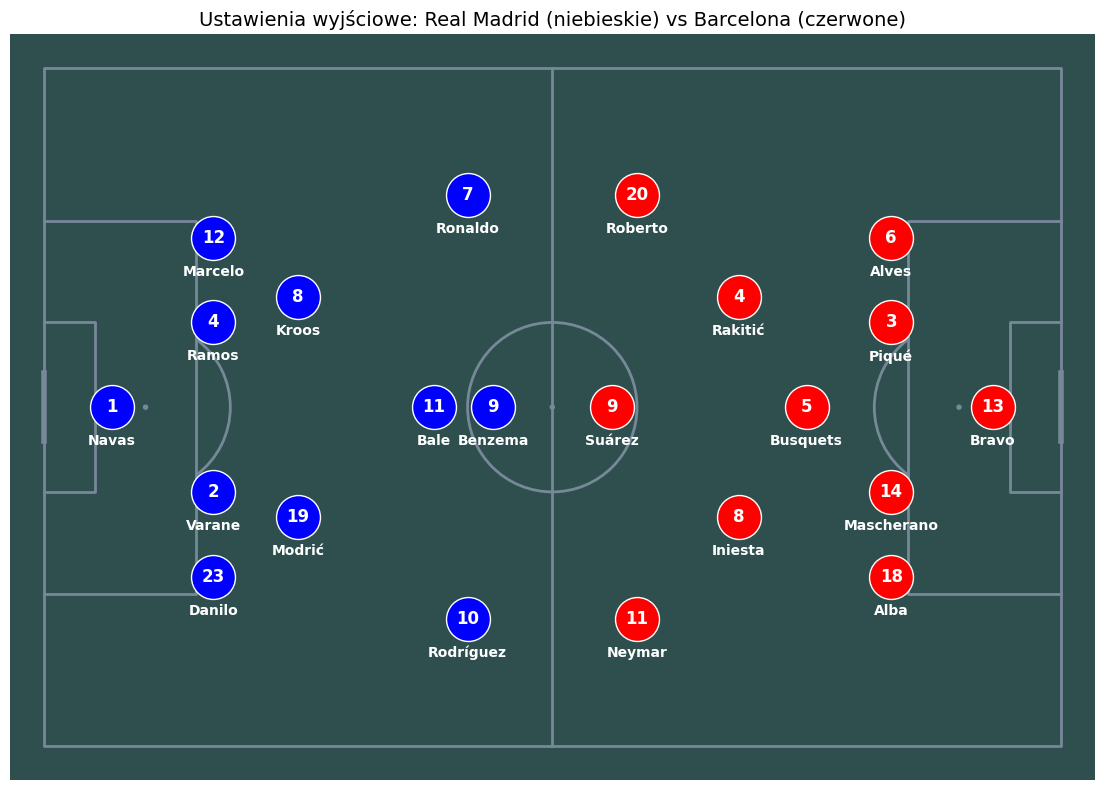

In [7]:
position_coordinates = utils.get_coordinates()

starting_home = events[(events['type'] == 'Starting XI') & (events['team'] == home_team)].iloc[0]
starting_away = events[(events['type'] == 'Starting XI') & (events['team'] == away_team)].iloc[0]

players_home = starting_home['tactics']['lineup']
players_away = starting_away['tactics']['lineup']

# Boisko
pitch = Pitch(pitch_type='statsbomb', pitch_color='darkslategrey', line_color='lightslategrey')
fig, ax = pitch.draw(figsize=(12, 8))

# Gospodarze (po lewej)
for player in players_home:
    name = player['player']['name']
    number = player['jersey_number']
    position = player['position']['name']
    x, y = position_coordinates.get(position, (10, 10))

    pitch.scatter(x, y, ax=ax, s=1000, color='blue', edgecolors='white', zorder=3)
    ax.text(x, y, str(number), color = 'white',va='center', ha='center', fontsize=12, fontweight='bold', zorder=4)
    ax.text(x, y + 4, name.split()[-1], va='center', ha='center', fontsize=10, fontweight='bold', color='white', zorder=4)


# Goście (o prawej)
for player in players_away:
    name = player['player']['name']
    number = player['jersey_number']
    position = player['position']['name']
    x, y = position_coordinates.get(position, (10, 10))
    x = 120 - x
    y = 80 - y

    pitch.scatter(x, y, ax=ax, s=1000, color='red', edgecolors='white', zorder=3)
    ax.text(x, y, str(number), color = 'white', va='center', ha='center', fontsize=12, fontweight='bold', zorder=4)
    ax.text(x, y + 4, name.split()[-1], va='center', ha='center', fontsize=10, fontweight='bold', color='white', zorder=4)


# Tytuł
plt.title(f"Ustawienia wyjściowe: {home_team} (niebieskie) vs {away_team} (czerwone)", fontsize=14)
plt.show()


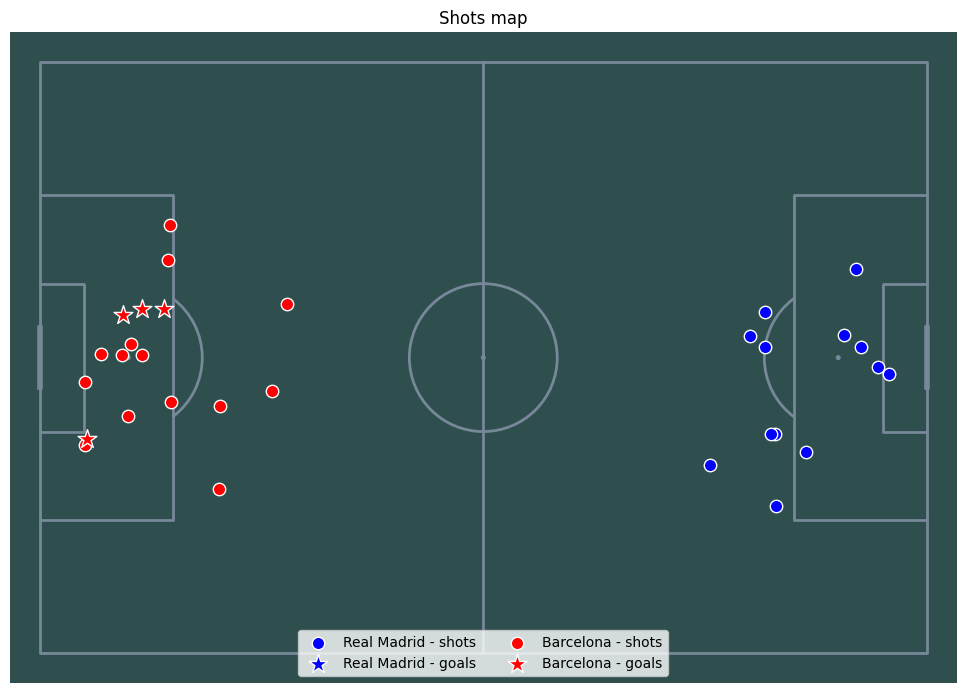

In [8]:
#mapa strzałów

shots = events[(events['type'] == 'Shot') & (events['location'])].copy()
shots['x'] = shots['location'].apply(lambda loc: loc[0])
shots['y'] = shots['location'].apply(lambda loc: loc[1])


shots.loc[shots['team'] == away_team, 'x'] = 120 - shots['x']
shots.loc[shots['team'] == away_team, 'y'] = 80 - shots['y']

home_shots = shots[shots['team'] == home_team]
away_shots = shots[shots['team'] == away_team]

home_goals = home_shots[home_shots['shot_outcome'] == 'Goal']
home_others = home_shots[home_shots['shot_outcome'] != 'Goal']

away_goals = away_shots[away_shots['shot_outcome'] == 'Goal']
away_others = away_shots[away_shots['shot_outcome'] != 'Goal']

pitch = Pitch(pitch_type='statsbomb', pitch_color='darkslategrey', line_color='lightslategrey')
fig, ax = pitch.draw(figsize=(10, 7))

#Strzały gospodarzy
pitch.scatter(
    home_others['x'], home_others['y'],
    ax=ax, c='blue', edgecolors='white', s=80, label=f'{home_team} - shots'
)
#Gole gospodarzy
pitch.scatter(
    home_goals['x'], home_goals['y'],
    ax=ax, c='blue', edgecolors='white', s=200, marker='*', label=f'{home_team} - goals'
)

#Strzały gości
pitch.scatter(
    away_others['x'], away_others['y'],
    ax=ax, c='red', edgecolors='white', s=80, label=f'{away_team} - shots'
)
#Gole gości
pitch.scatter(
    away_goals['x'], away_goals['y'],
    ax=ax, c='red', edgecolors='white', s=200, marker='*', label=f'{away_team} - goals'
)

plt.title('Shots map')
plt.legend(loc='lower center', ncol=2)
plt.tight_layout()
plt.show()


             player         team  passes
12       Jordi Alba    Barcelona      78
26       Toni Kroos  Real Madrid      67
0    Andrés Iniesta    Barcelona      66
3        Dani Alves    Barcelona      65
24  Sergio Busquets    Barcelona      61
18      Luka Modrić  Real Madrid      54
21           Neymar    Barcelona      52
7      Gerard Piqué    Barcelona      47
9      Ivan Rakitić    Barcelona      46
23    Sergi Roberto    Barcelona      42
13   Jérémy Mathieu    Barcelona      36
22   Raphaël Varane  Real Madrid      34
25     Sergio Ramos  Real Madrid      33
5            Danilo  Real Madrid      33
1     Claudio Bravo    Barcelona      29


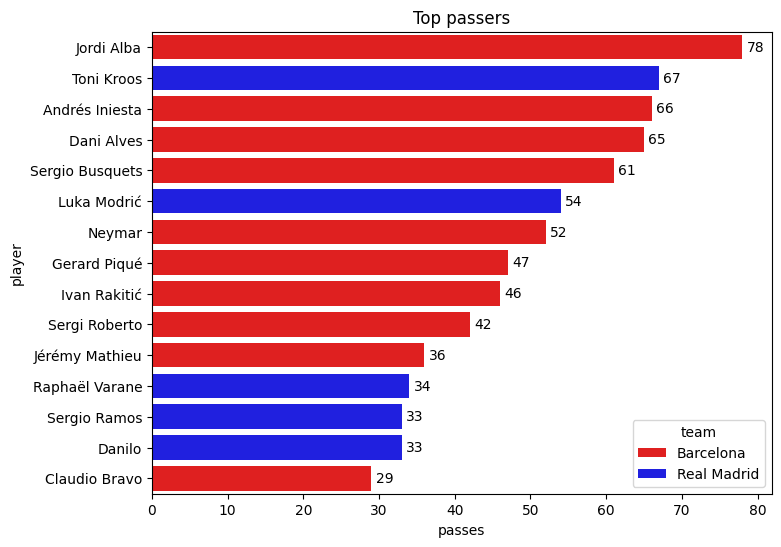

In [9]:
top_passes = (
    events[
    (events['type'] == 'Pass') &
    (events['pass_outcome'].isnull()) &
    (events['location'].notnull()) &
    (events['pass_end_location'].notnull()) &
    (events['player'].notnull()) &
    (events['team'].notnull()) &
    (events['pass_recipient'].notnull())]
    .copy()
    .groupby(['player', 'team'])
    .size()
    .reset_index(name='passes')
    .sort_values(by='passes', ascending = False)
    .head(15)
)
print(top_passes)

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=top_passes,
    y='player',
    x='passes',
    hue='team',
    palette=('red', 'blue')
)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.title('Top passers')
plt.xlabel('passes')
plt.ylabel('player')
plt.legend(title='team')
plt.gca()
plt.show()


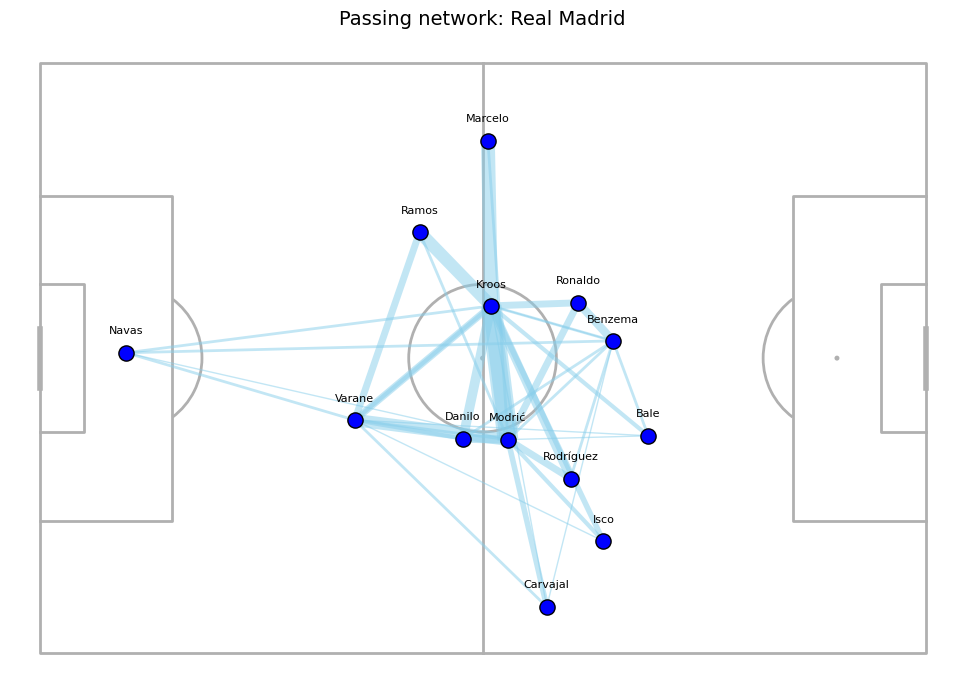

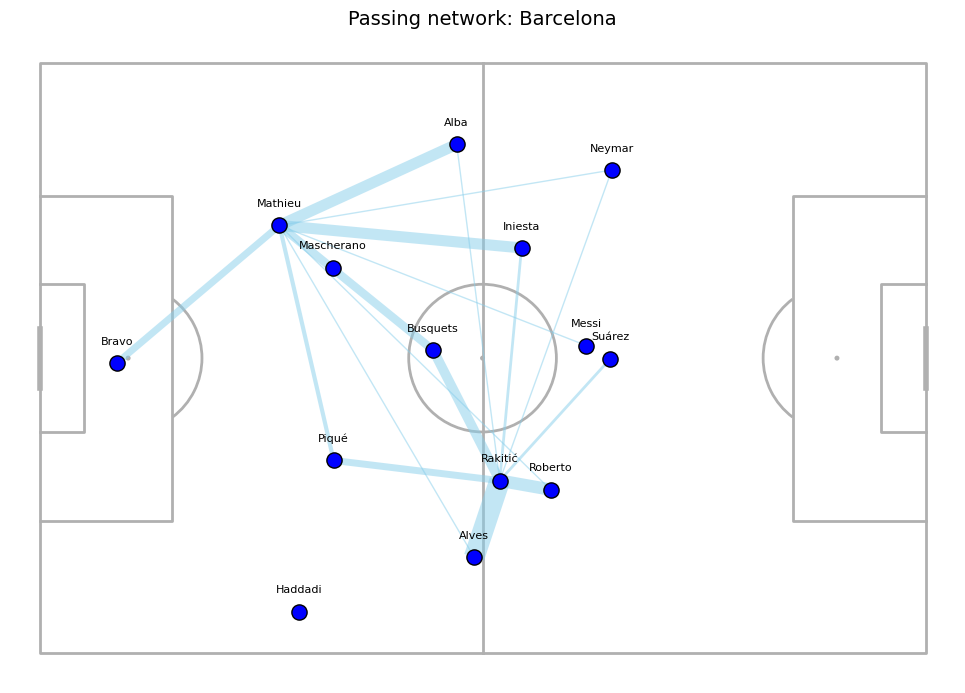

In [10]:
# Siatki podań
passes = events[
    (events['type'] == 'Pass') &
    (events['pass_outcome'].isnull()) &
    (events['location'].notnull()) &
    (events['pass_end_location'].notnull()) &
    (events['player'].notnull()) &
    (events['team'].notnull()) &
    (events['pass_recipient'].notnull())].copy()

teams = home_team, away_team
passes_by_team = {team: passes[passes['team'] == team] for team in teams}

def create_pass_network(passes, team_name):
    #średnie pozycje 
    avg_locs = passes.groupby('player').agg(
        x=('location', lambda locs: np.mean([loc[0] for loc in locs])),
        y=('location', lambda locs: np.mean([loc[1] for loc in locs])),
        count=('player', 'count')
    ).reset_index()

    #pary zawodników
    combinations = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='count')
    combinations = combinations[combinations['pass_recipient'].notnull()]

    loc_dict = avg_locs.set_index('player')[['x', 'y']].to_dict('index')

    pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
    fig, ax = pitch.draw(figsize=(10, 7))
    plt.title(f'Passing network: {team_name}', fontsize=14)

    # linie między parami
    for _, row in combinations.iterrows():
        p1, p2 = row['player'], row['pass_recipient']
        if p1 in loc_dict and p2 in loc_dict:
            x1, y1 = loc_dict[p1]['x'], loc_dict[p1]['y']
            x2, y2 = loc_dict[p2]['x'], loc_dict[p2]['y']
            pitch.lines(x1, y1, x2, y2, ax=ax, lw=row['count'], color='skyblue', alpha=0.5)

    # zaowdnicy
    pitch.scatter(avg_locs['x'], avg_locs['y'], s=120, ax=ax,
                  color='blue', edgecolors='black', zorder=3)

    for _, row in avg_locs.iterrows():
        pitch.annotate(row['player'].split(" ")[-1], (row['x'], row['y']-2.5), ax=ax, fontsize=8, ha='center')

    return fig, ax

for team, team_passes in passes_by_team.items():
    create_pass_network(team_passes, team)
    plt.show()

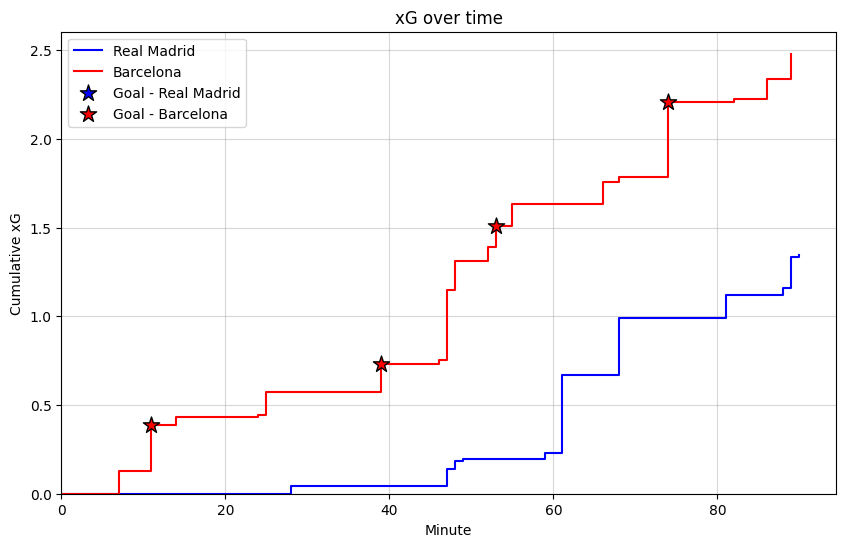

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

shots = events[
    (events['type'] == 'Shot') &
    (events['shot_statsbomb_xg'].notnull()) &
    (events['team'].notnull())
].copy()

home_xg = shots[shots['team'] == home_team].copy()
away_xg = shots[shots['team'] == away_team].copy()

home_xg['cumulative_xg'] = home_xg['shot_statsbomb_xg'].cumsum()
away_xg['cumulative_xg'] = away_xg['shot_statsbomb_xg'].cumsum()

home_xg = pd.concat([pd.DataFrame([{'minute': 0, 'cumulative_xg': 0}]), home_xg], ignore_index=True)
away_xg = pd.concat([pd.DataFrame([{'minute': 0, 'cumulative_xg': 0}]), away_xg], ignore_index=True)

home_goals = home_xg[home_xg.get('shot_outcome') == 'Goal']
away_goals = away_xg[away_xg.get('shot_outcome') == 'Goal']

plt.figure(figsize=(10, 6))
plt.step(home_xg['minute'], home_xg['cumulative_xg'], where='post', label=home_team, color='blue')
plt.step(away_xg['minute'], away_xg['cumulative_xg'], where='post', label=away_team, color='red')
plt.scatter(home_goals['minute'], home_goals['cumulative_xg'], color='blue', marker='*', s=150, edgecolor='black', zorder=4, label='Goal - ' + home_team)
plt.scatter(away_goals['minute'], away_goals['cumulative_xg'], color='red', marker='*', s=150, edgecolor='black', zorder=4, label='Goal - ' + away_team)

plt.title('xG over time')
plt.xlabel('Minute')
plt.ylabel('Cumulative xG')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

